In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import os


In [7]:
pip install pydub

In [2]:
from pydub import AudioSegment

In [3]:
def load_audio(file_path, sr=16000):
    """Load audio from an MP4 file and return the signal and sample rate."""
    audio = AudioSegment.from_file(file_path, format="mp4")
    audio = audio.set_frame_rate(sr).set_channels(1)  # Convert to mono
    samples = np.array(audio.get_array_of_samples()).astype(np.float32) / 32768.0  # Normalize
    return samples, sr

def stft_noise_reduction(signal, sr, threshold=0.05):
    """Apply STFT-based noise reduction."""
    stft_transform = librosa.stft(signal)
    magnitude, phase = np.abs(stft_transform), np.angle(stft_transform)
    magnitude[magnitude < threshold * np.max(magnitude)] = 0
    denoised_signal = librosa.istft(magnitude * np.exp(1j * phase))
    return denoised_signal

def extract_mfcc(signal, sr, n_mfcc=13):
    """Extract MFCC features from the audio signal."""
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)  #the mean MFCCs across frames

def apply_pca(features, n_components=10):
    """Apply PCA to reduce feature dimensions."""
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features

def train_svm(X_train, y_train, kernel="poly", degree=3):
    """Train an SVM classifier."""
    clf = SVC(kernel=kernel, degree=degree, probability=True)
    clf.fit(X_train, y_train)
    return clf

def train_rf(X_train, y_train, n_estimators=100):
    """Train a Random Forest classifier."""
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    clf.fit(X_train, y_train)
    return clf


In [4]:
import os
from pydub import AudioSegment

os.environ["FFMPEG_BINARY"] = r"C:\Users\Neermita Bhattachary\Downloads\ffmpeg-7.1-full_build\ffmpeg-7.1-full_build\bin\ffmpeg.exe"
os.environ["FFPROBE_BINARY"] = r"C:\Users\Neermita Bhattachary\Downloads\ffmpeg-7.1-full_build\ffmpeg-7.1-full_build\bin\ffprobe.exe"

AudioSegment.converter = os.environ["FFMPEG_BINARY"]
AudioSegment.ffprobe = os.environ["FFPROBE_BINARY"]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
SVM Classification Accuracy: 68.00%
              precision    recall  f1-score   support

           0       0.80      0.57      0.67        14
           1       0.60      0.82      0.69        11

    accuracy                           0.68        25
   macro avg       0.70      0.69      0.68        25
weighted avg       0.71      0.68      0.68        25

Random Forest Classification Accuracy: 76.00%
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.69      0.82      0.75        11

    accuracy                           0.76        25

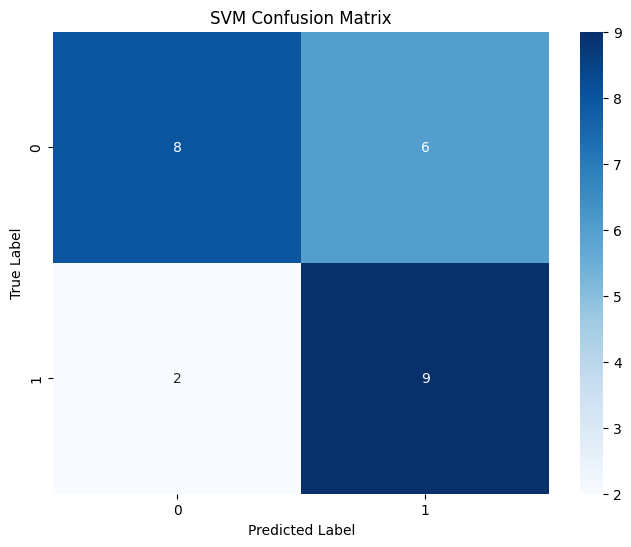

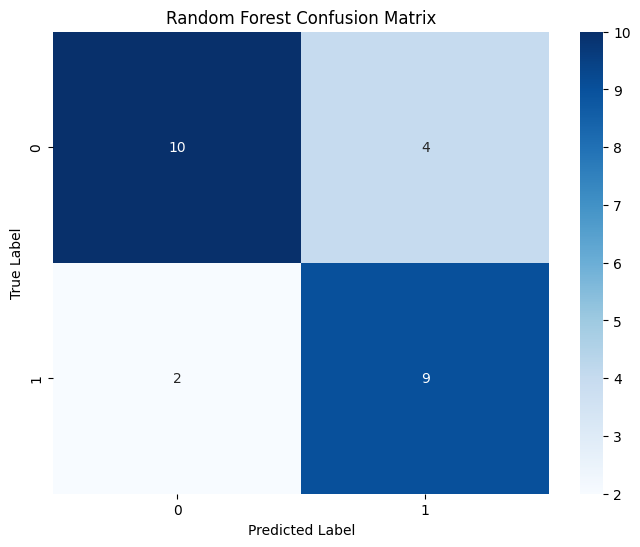

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#annotation !! more features !!
annotation_path = "RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Annotation/All_Gestures_Deceptive and Truthful.csv"
annotations = pd.read_csv(annotation_path)
annotations=annotations.drop(columns=["class"])
truthful_dir = "RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Clips/Truthful/"
deceptive_dir = "RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Clips/Deceptive/"
X, y= [], []
features_df = []

for i, row in annotations.iterrows():
    print(i)
    file_name = row['id']
    file_path = os.path.join(truthful_dir if 'truth' in file_name else deceptive_dir, file_name)
    
    if os.path.exists(file_path):
        signal, sr = load_audio(file_path)
        clean_signal = stft_noise_reduction(signal, sr)
        mfcc_features = extract_mfcc(clean_signal, sr)
        annotation_features = row.iloc[1:].values.astype(float)
        combined_features = np.concatenate((mfcc_features, annotation_features))
        
        X.append(combined_features)
        y.append(1 if 'truth' in file_name else 0)

X, y = np.array(X), np.array(y)
X_pca = apply_pca(X, n_components=10)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

#SVM
svm_model = train_svm(X_train, y_train, kernel="rbf")
y_pred_svm = svm_model.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Classification Accuracy: {acc_svm * 100:.2f}%")
print(classification_report(y_test, y_pred_svm))

#Random Forest
rf_model = train_rf(X_train, y_train, n_estimators=100)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Classification Accuracy: {acc_rf * 100:.2f}%")
print(classification_report(y_test, y_pred_rf))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("svm_confusion_matrix.png")  # Save the figure
plt.show()

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("rf_confusion_matrix.png")  # Save the figure
plt.show()

In [13]:
X_train.shape

(96, 10)

In [14]:
 X_test.shape

(25, 10)

In [15]:
 y_train.shape

(96,)

In [16]:
y_test.shape

(25,)

In [18]:
X.shape

(121, 52)

In [20]:
annotation_features.shape

(39,)